In [1]:
from keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from keras.layers import Input, Dense
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.layers import concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, MaxPooling2D, Dense, UpSampling2D, Reshape, Flatten, BatchNormalization, Lambda
from keras.layers import LeakyReLU, Input, Dropout, Conv2DTranspose
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.applications import ResNet50
from keras import backend as K
from keras import losses
from keras.models import load_model
from keras.regularizers import L1L2
from keras.preprocessing.sequence import Sequence
from multiprocessing import Pool
from random import shuffle
from tqdm import tqdm_notebook
import os
import re
import cv2

/home/alexey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def resize_coeff(x, new_x):
    """
    Evaluate resize coefficient from image shape
    Args:
        x: original value
        new_x: expect value

    Returns:
        Resize coefficient
    """
    return new_x / x


def resize_image(img, resize_shape=(128, 128), interpolation=cv2.INTER_AREA):
    """
    Resize single image
    Args:
        img: input image
        resize_shape: resize shape in format (height, width)
        interpolation: interpolation method

    Returns:
        Resize image
    """
    return cv2.resize(img, None, fx=resize_coeff(img.shape[1], resize_shape[1]),
                      fy=resize_coeff(img.shape[0], resize_shape[0]),
                      interpolation=interpolation)


class BatchDataLoaderByImagesPaths(Sequence):
    def __init__(self, x_set, y_set, shape, batch_size, drop_last=True):
        """
        Class constructor
        Args:
            x_set: images paths list
            y_set: y_true list
            batch_size: batch size
            drop_last: drop last batch
        """
        assert batch_size > 0

        self.x, self.y = list(x_set), list(y_set)
        self.is_train = True

        assert (len(self.x) == len(self.y)) or \
               (drop_last and (abs(len(self.x) - len(self.y)) < batch_size))

        self.batch_size = batch_size
        self.shape = shape

        if not drop_last:
            self._pad()
            
    def _pad(self):
        for i in range(len(self.x) - (len(self.x) // self.batch_size)):
            self.x.append(self.x[-1])
            self.y.append(self.y[-1])

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, idx):
        batch_x = [
            resize_image(
                cv2.imread(p, 0), self.shape
            ).reshape(self.shape) / 255.
            for p in self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        ]

        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        if 'str' in str(type(batch_y[0])) and len(batch_y[0]) > 1:
            batch_y = [
                resize_image(
                    cv2.imread(p, 0), self.shape
                ).reshape(self.shape) / 255.
                for p in batch_y
            ]

        if not self.is_train:
            return np.array(batch_x)
        return batch_x, batch_y

    def eval(self):
        self.is_train = False

    def train(self):
        self.is_train = True


In [3]:
dirs = ['4a', '4b', '4c', '4d', '4e', '4f', '5a', '6a', '6b', '6c', '6d', '6e',
        '6f', '7a', '30', '31', '32', '33',
            '34', '35', '36', '37', '38', '39', '41', '42', '43', '44', '45',
        '46', '47', '48', '49', '50',
            '51', '52', '53', '54', '55', '56', '57', '58', '59', '61', '62',
        '63', '64', '65', '66', '67', '68', '69',
            '70',
            '71', '72', '73', '74', '75', '76', '77', '78', '79']

classes = ['J', 'K', 'L', 'M', 'N', 'O', 'Z', 'j', 'k', 'l', 'm', 'n', 'o',
           'z', '0', '1', '2', '3',
               '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F',
           'G', 'H', 'I', 'P',
               'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c',
           'd', 'e', 'f', 'g', 'h', 'i', 'p',
               'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


def flatten_list(lst):
    res = []
    for l in lst:
        for e in l:
            res.append(e)
    return res


def get_one_hot_label(label):
    return classes.index(label)


def generate_imgs_tuple(path):
    supdirs = list(set(['hsf_{}'.format(i) for i in range(8)]) - set(['hsf_5']))

    base_path = os.path.join(path, 'by_class')

    classes_dirs_tuple = {
        c: [base_path + '/' + d + '/' + s + '/' for s in supdirs] +
           [base_path + '/' + d + '/train_' + d + '/']
        for c, d in zip(classes, dirs)
    }

    classes_imgs_tuple = {
        c: flatten_list(
            [[d + img_name for img_name in os.listdir(d)] for d in drs_list])
        for c, drs_list in classes_dirs_tuple.items()
    }

    return classes_imgs_tuple


def check_to_image_exist(sample):
    return cv2.imread(sample[1], 0) is not None


def generate_paths(path):
    classes_imgs_tuple = generate_imgs_tuple(path)

    _label_img_store = [
        (label, img) for label in classes for img in classes_imgs_tuple[label]
    ]

    return _label_img_store


In [4]:
origin_dataset = generate_paths('../../HandwrittenCharacterGenerator/data/')

In [101]:
shuffled_dataset = origin_dataset.copy()
shuffle(shuffled_dataset)

dataset = np.array([
        [d[0], d[1]]
        for d in shuffled_dataset[:4096]
    ])

imgs_paths = dataset[:, 1]
labels = dataset[:, 0]

x_train_generator = BatchDataLoaderByImagesPaths(
    imgs_paths,
    labels,
    (28, 28, 1),
    batch_size
)

In [102]:
len(x_train_generator)*batch_size

4096

In [11]:
x_train_generator[0][0][0].shape

(28, 28, 1)

d


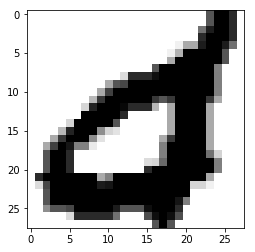

In [12]:
ind = 0
print(x_train_generator[ind][1][0])
plt.gray()
plt.imshow(x_train_generator[ind][0][0].reshape(28, 28))

In [5]:
#plt.figure(figsize=(12,10))
#plt.scatter(p_field[:, 0], p_field[:, 1], c=images_labels,#color='blue', 
#            edgecolor='none', alpha=0.7, s=40,
#            cmap=plt.cm.get_cmap('nipy_spectral', 10))
#plt.colorbar()
#plt.title('images projection')

#print(p_field.shape)
#print(tsne.get_params(True))

In [5]:
def load_last_weights(model, path, logger=None):
    if not os.path.isdir(path):
        os.makedirs(path)

    weights_files_list = [
        matching_f.group()
        for matching_f in map(
            lambda x: re.match('vae-\d+-\d+-\d+-\d+.h5', x),
            os.listdir(path)
        ) if matching_f if not None
    ]

    if len(weights_files_list) == 0:
        return 0

    weights_files_list.sort(key=lambda x: -int(x.split('-')[1]))

    model.load_weights(os.path.join(path, weights_files_list[0]))

    if logger is not None:
        logger.debug('LOAD MODEL PATH: {}'.format(
            os.path.join(path, weights_files_list[0])
        ))
    else:
        print('LOAD MODEL PATH: {}'.format(
            os.path.join(path, weights_files_list[0])
        ))

    return int(weights_files_list[0].split('-')[1])

In [6]:
from keras.layers import Input, Dense
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.layers import concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, MaxPooling2D, Dense, UpSampling2D, Reshape, Flatten, BatchNormalization, Lambda, Conv2DTranspose
from keras.layers import LeakyReLU, Input, Dropout, Conv2DTranspose
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.applications.resnet50 import ResNet50
from keras import backend as K
from keras import losses
from keras.models import load_model
from keras.regularizers import L1L2
import tensorflow as tf
import os
import re


def create_conv_vae(input_shape, latent_dim, dropout_rate, batch_size,
                start_lr=0.0001):
    models = {}

    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    input_img = Input(shape=input_shape)

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                  stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    z = Input(shape=(latent_dim,))

    x = LeakyReLU()(z)
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 1))(x)
    x = apply_bn_and_dropout(x)
    x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = apply_bn_and_dropout(x)
    x = Conv2DTranspose(128, (7, 7), activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = Conv2D(1, (7, 7), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(x)
    decoded = Reshape((input_shape[0], input_shape[1], input_shape[2]))(x)

    models["encoder"] = Model(input_img, l, 'Encoder')
    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean')
    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var')

    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, input_shape[0] * input_shape[1]*input_shape[2]))
        decoded = K.reshape(decoded, shape=(batch_size, input_shape[0] * input_shape[1]*input_shape[2]))
        xent_loss = input_shape[0] * input_shape[2] * input_shape[1]*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/input_shape[0]/input_shape[1]/input_shape[2]

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"] = Model(input_img,
                          models["decoder"](models["encoder"](input_img)),
                          name="VAE")

    models["vae"].compile(optimizer=Adam(lr=start_lr), loss=vae_loss)

    return models, vae_loss


def create_vae(input_shape, latent_dim, dropout_rate, batch_size,
                start_lr=0.001):
    models = {}

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(shape=input_shape)
    x = Flatten()(input_img)
    x = Dense(256, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = Dense(128, activation='relu')(x)
    x = apply_bn_and_dropout(x)

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, 'Encoder')
    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean')
    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var')

    # Декодер
    z = Input(shape=(latent_dim, ))
    x = Dense(128)(z)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(x)
    decoded = Reshape((input_shape[0], input_shape[1], 1))(x)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, input_shape[0] * input_shape[1]))
        decoded = K.reshape(decoded, shape=(batch_size, input_shape[0] * input_shape[1]))
        xent_loss = input_shape[0] * input_shape[1]*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/input_shape[0]/input_shape[1]

    models["vae"].compile(optimizer=Adam(lr=start_lr), loss=vae_loss)

    return models, vae_loss


def load_last_weights(model, path, logger=None):
    if path is None:
        return 0

    if not os.path.isdir(path):
        os.makedirs(path)

    weights_files_list = [
        matching_f.group()
        for matching_f in map(
            lambda x: re.match('vae-\d+-\d+-\d+-\d+.h5', x),
            os.listdir(path)
        ) if matching_f if not None
    ]

    if len(weights_files_list) == 0:
        return 0

    weights_files_list.sort(key=lambda x: -int(x.split('-')[1]))

    model.load_weights(os.path.join(path, weights_files_list[0]))

    if logger is not None:
        logger.debug('LOAD MODEL PATH: {}'.format(
            os.path.join(path, weights_files_list[0])
        ))
    else:
        print('LOAD MODEL PATH: {}'.format(
            os.path.join(path, weights_files_list[0])
        ))

    return int(weights_files_list[0].split('-')[1])


In [7]:
!pwd

/home/alexey/programming/Clustering-by-VAE/nist19


In [8]:
batch_size = 1024
latentdim = 10

models, _ = create_conv_vae(
        input_shape=(28, 28, 1),
        latent_dim=latentdim,
        dropout_rate=0.4,
        batch_size=batch_size
    )

vae = models["vae"]

vae.load_weights('../data/nist19/vae10/vae-31-10-1024-28.h5')

print(vae.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Encoder (Model)              (None, 10)                54196     
_________________________________________________________________
Decoder (Model)              (None, 28, 28, 1)         3422261   
Total params: 3,476,457
Trainable params: 3,476,391
Non-trainable params: 66
_________________________________________________________________
None


In [96]:
from keras.utils import plot_model
plot_model(models['z_meaner'], to_file='../data/plots/decoder_conv_vae_10.png', show_shapes=True)

In [103]:
x_train_generator.eval()
X_encode = models['z_meaner'].predict_generator(x_train_generator, steps=len(x_train_generator))

In [82]:
N = 1024
x_train_generator.eval()
X_encode = models['z_meaner'].predict_generator(x_train_generator, steps=len(x_train_generator))
x_train_generator.train()

In [104]:
y = np.array([classes.index(label) for label, _ in dataset], dtype=int)

In [105]:
y.shape

(4096,)

In [106]:
X_encode.shape

(4096, 10)

In [16]:
x_train_generator.eval()
imgs = models["vae"].predict_generator(x_train_generator, steps=len(x_train_generator))

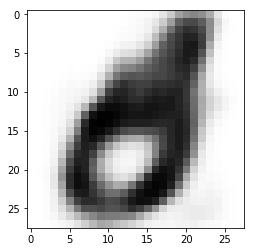

In [42]:
imgs.shape
plt.imshow(imgs.reshape(28, 28))

Text(0.5,1,'images projection')

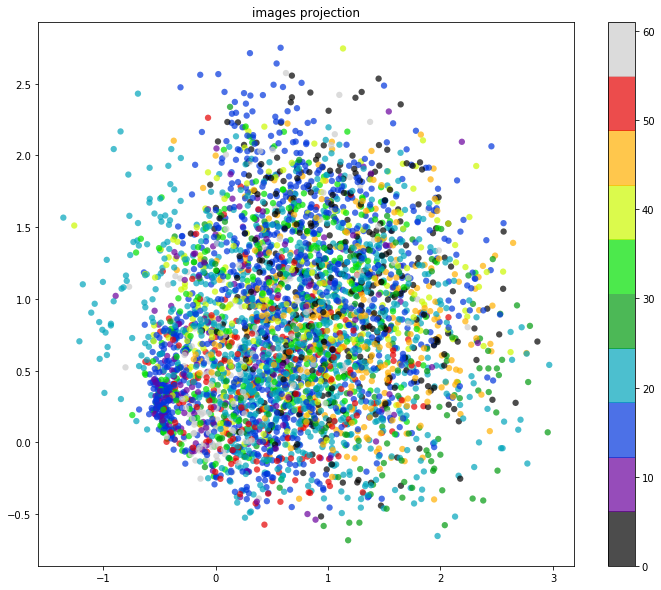

In [107]:
data = X_encode

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

In [108]:
X_encode[0]

array([-0.03700365,  0.7115832 , -0.15694132,  0.7250778 ,  0.2938489 ,
       -0.00929103,  0.49152163, -0.20786992,  0.39768746, -0.6141474 ],
      dtype=float32)

In [109]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)

p_field = tsne.fit_transform(X_encode)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4096 samples in 0.003s...
[t-SNE] Computed neighbors for 4096 samples in 0.382s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4096
[t-SNE] Computed conditional probabilities for sample 2000 / 4096
[t-SNE] Computed conditional probabilities for sample 3000 / 4096
[t-SNE] Computed conditional probabilities for sample 4000 / 4096
[t-SNE] Computed conditional probabilities for sample 4096 / 4096
[t-SNE] Mean sigma: 0.592925
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.061134
[t-SNE] Error after 1000 iterations: 1.584593


Text(0.5,1,'images projection')

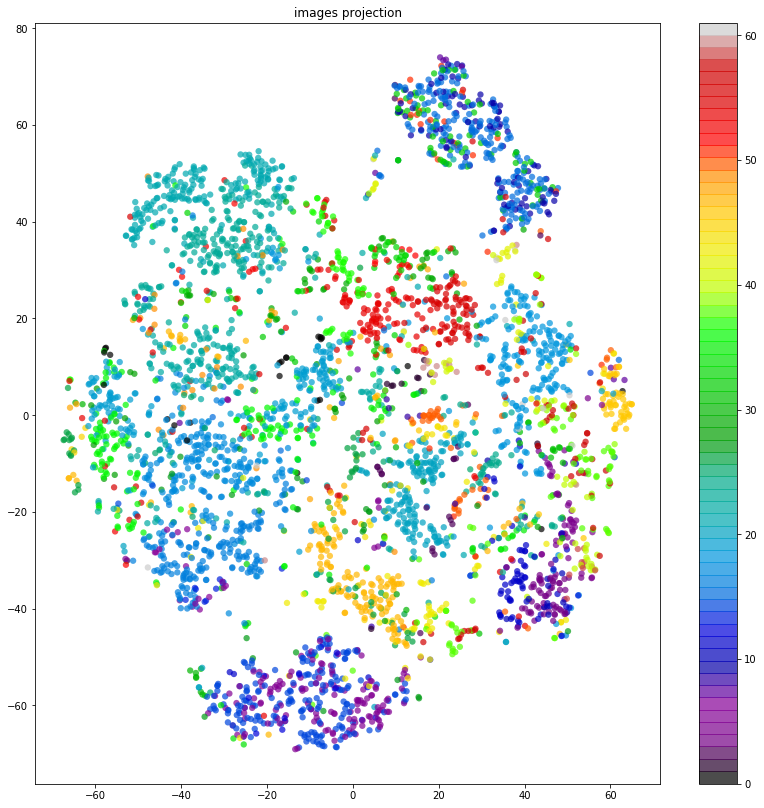

In [110]:
#Convolutional VAE version 2 latent dimention 16 on 305 epoch
data = p_field

plt.figure(figsize=(14,14))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', len(classes)))
plt.colorbar()
plt.title('images projection')

Text(0.5,1,'images projection')

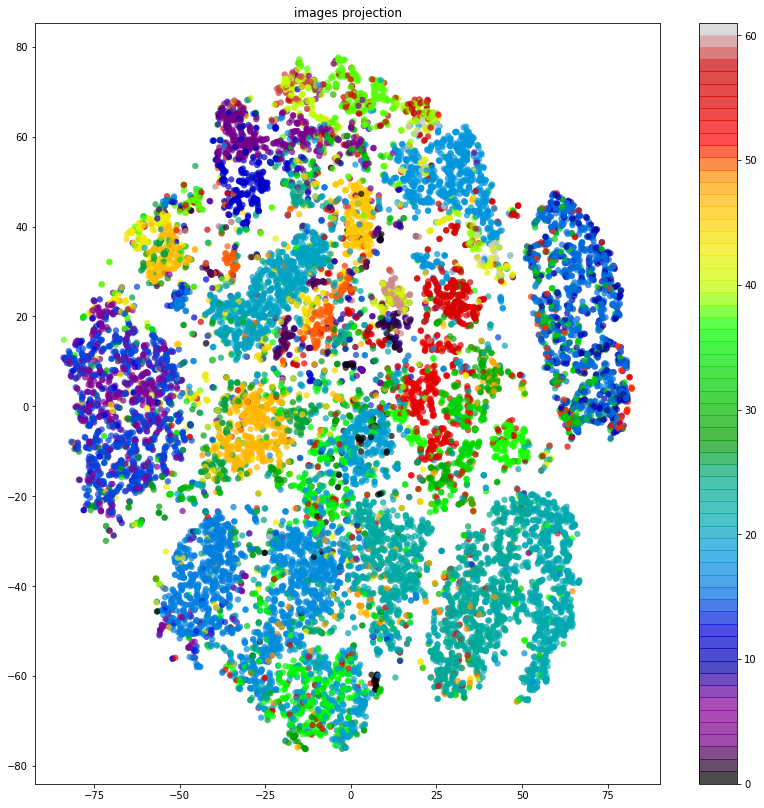

In [66]:
#Convolutional VAE version 2 latent dimention 16 on 305 epoch
data = p_field

plt.figure(figsize=(14,14))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', len(classes)))
plt.colorbar()
plt.title('images projection')

(5000, 10)


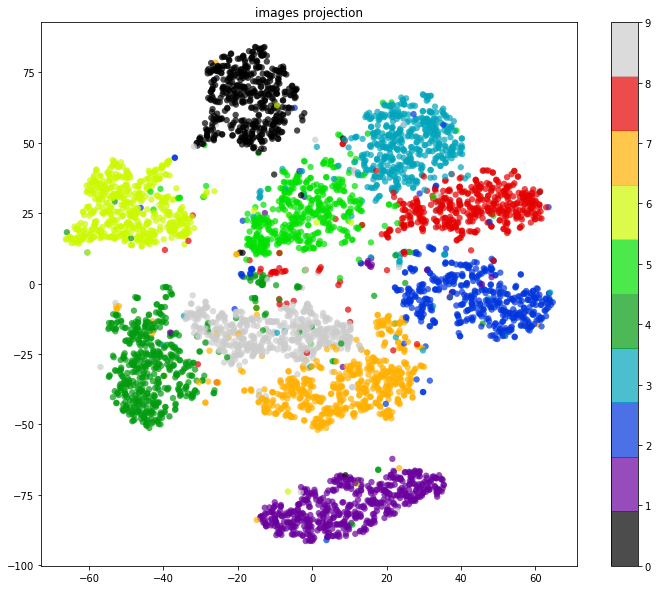

In [25]:
#Convolutional VAE version 2 latent dimention 10 on 73 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 32)


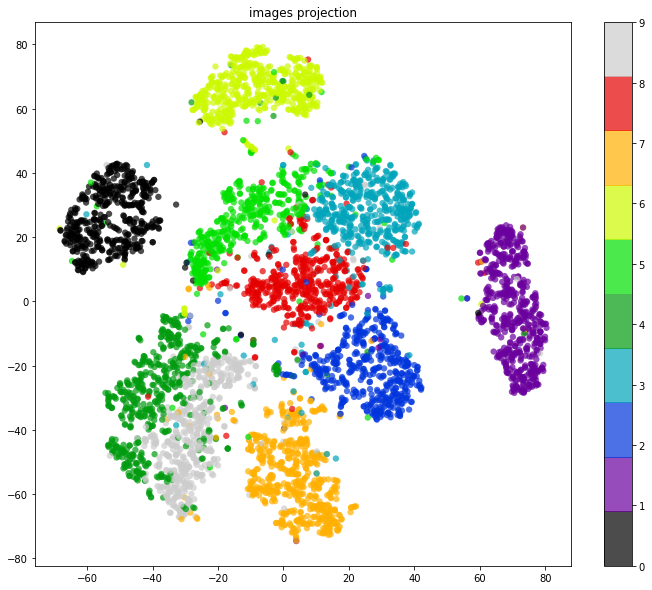

In [190]:
#VAE latent dimention 32 on 500 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 32)


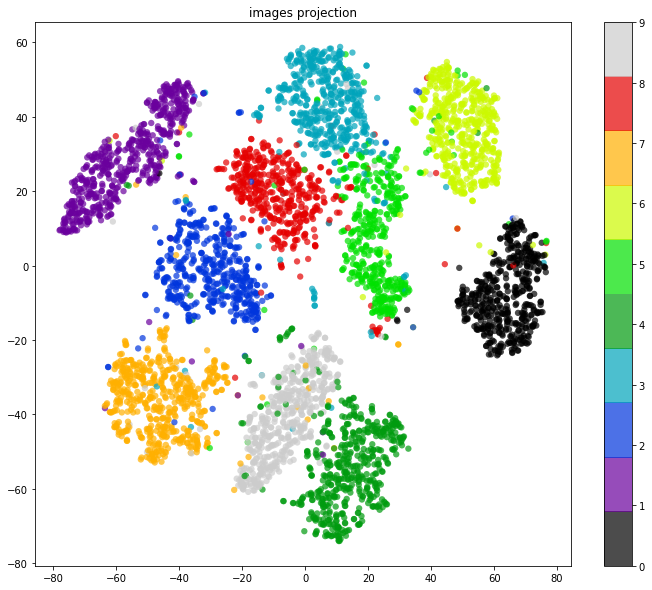

In [184]:
#Convolution VAE latent dimention 32 on 500 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 10)


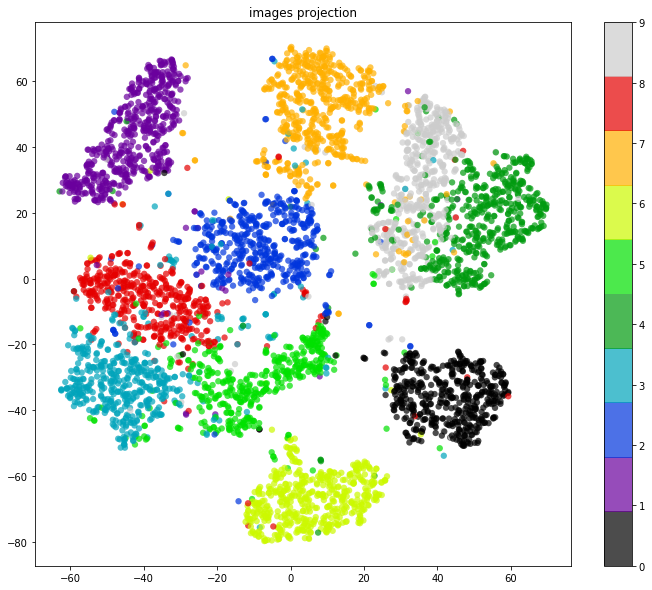

In [180]:
#Convolution VAE latent dimention 10 on 500 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 10)


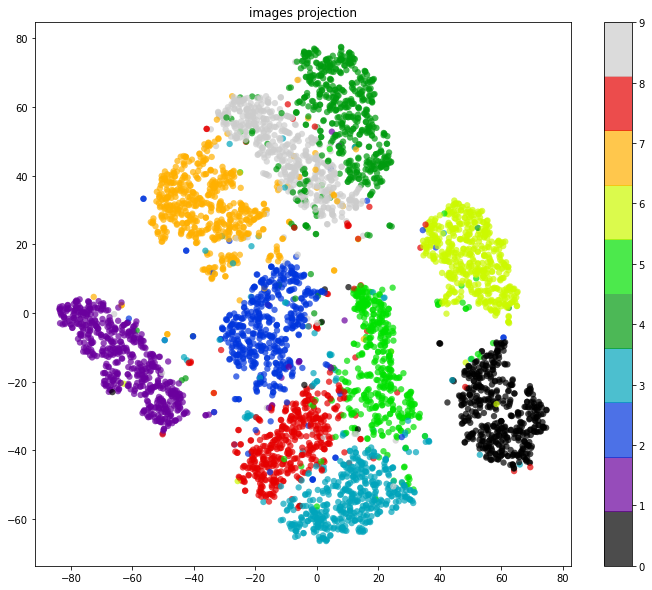

In [152]:
#Convolution VAE latent dimention 10 on 233 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 10)


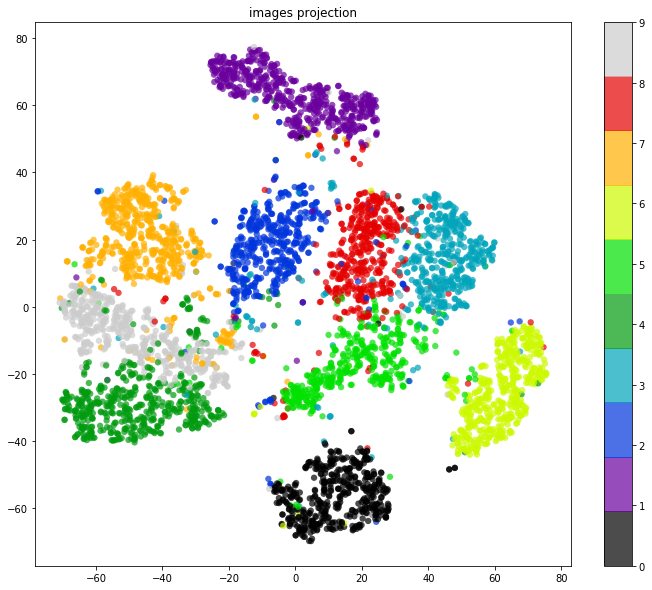

In [144]:
#Convolution VAE latent dimention 10 on 88 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 10)


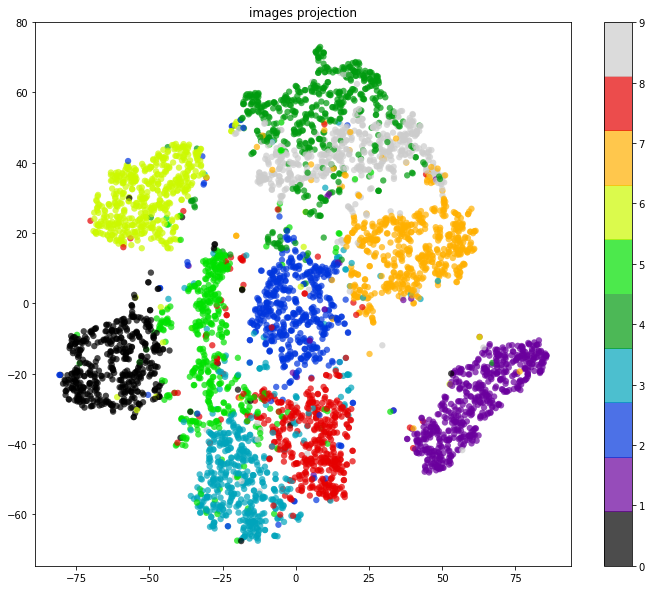

In [119]:
#VAE latent dimention 10
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.867905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.852013
[t-SNE] Error after 1000 iterations: 1.885289
(5000, 10)


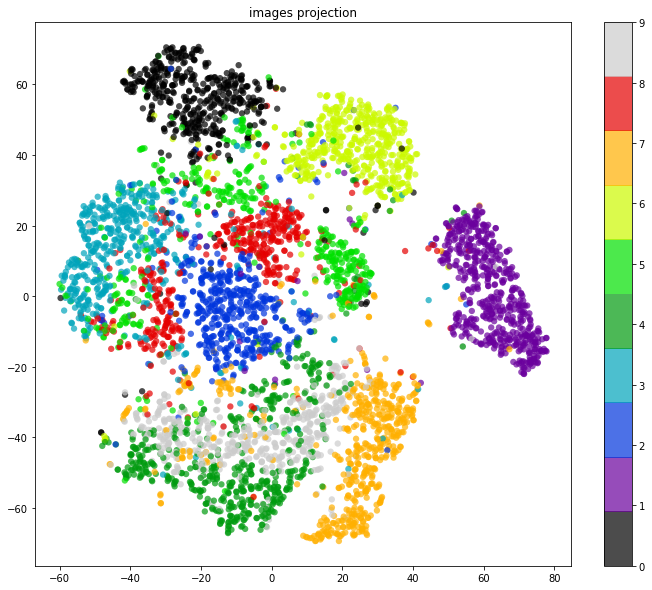

In [124]:
#VAE latent dimention 10 with logvar
X_encode = models['encoder'].predict(X, batch_size=1000)
tsne = TSNE(n_components=2, verbose=1)

p_field = tsne.fit_transform(X_encode)

data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
p_field = pca.fit_transform(X_encode)

(5000, 16)


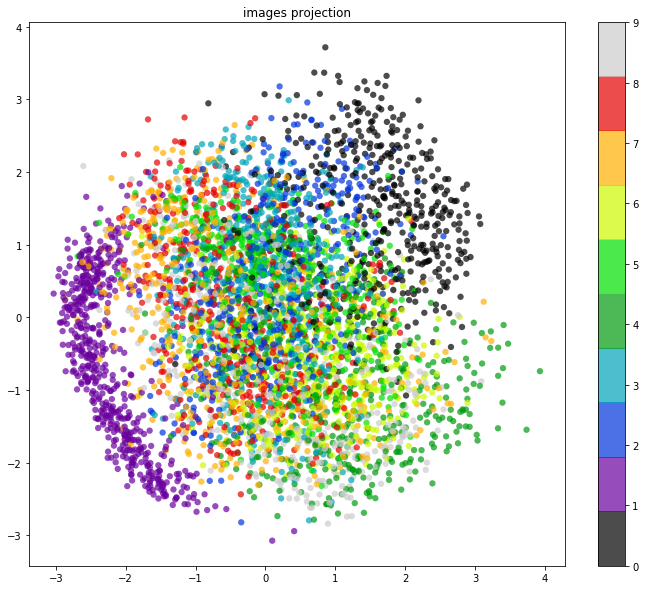

In [54]:
#VAE latent dimention 10 by PCA clustering
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

[(2, 0.6101869810934912), (3, 0.7214155460405066), (4, 0.5209524484730591), (5, 0.8800512549887501), (6, 0.8864204788518165), (7, 0.6355507641119316), (8, 0.6989061838537549), (9, 0.92151514302123), (10, 0.8999969242238497), (11, 0.8532319949191769)]


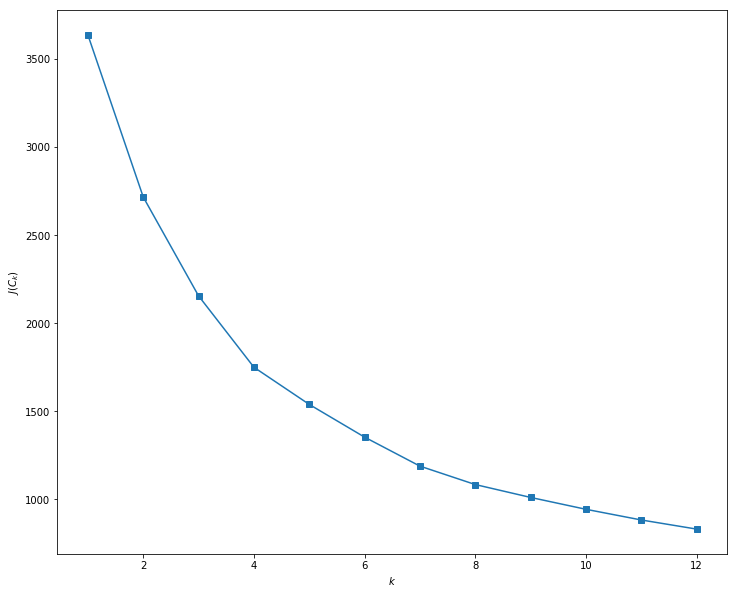

In [170]:
from sklearn.cluster import KMeans

N = [i + 1 for i in range(12)]
inertia = []
for k in N:
    kmeans = KMeans(n_clusters=k, random_state=1, n_jobs=4).fit(p_field)
    inertia.append(np.sqrt(kmeans.inertia_))

d_list = [(i + 1, abs((inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])))  for i in range(1, len(inertia) - 1)]
print(d_list)

plt.figure(figsize=(12,10))
plt.plot(N, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

/home/alexey/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/alexey/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


n_digits: 10, 	 n_samples 5000, 	 n_features 2
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.07s	618	0.827	0.827	0.827	0.784	0.826	0.506
random   	0.10s	618	0.827	0.827	0.827	0.784	0.826	0.504
PCA-based	0.01s	859916	0.774	0.789	0.781	0.675	0.773	0.512
__________________________________________________________________________________


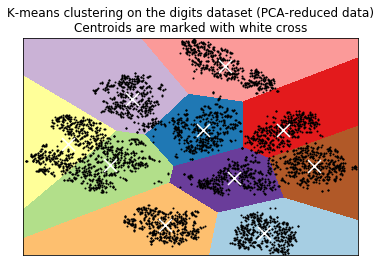

In [92]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(p_field)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = y

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = p_field
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=p_field)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = p_field
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(p_field)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [72]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN().fit(X_encode)

clustering.labels_[0:5]

array([ 0, -1, -1, -1, -1])

In [74]:
len(set(clustering.labels_))

36

In [99]:
def index_from_clustering_to_normal(index, values):
    for val in values:
        if val['cluster_ind'] == index:
            return val['class_ind']
    return -1

In [100]:
from sklearn.metrics import accuracy_score
Y = np.array(y)
accuracy_score(y, [index_from_clustering_to_normal(e, y_values) for e in clustering.labels_])

0.01171875

In [85]:
indexes = y == 0
#list(np.array(clustering.labels_)[indexes])

In [96]:
def count_of(lst, a):
    return len(list(filter(lambda x: x == a, lst)))

def target_index(lst, del_elements=set([-1])):
    labels = []
    _set = set(lst)
    if len(_set) > 1:
        _set -= del_elements
        
    for elem in _set:
        labels.append([elem, count_of(lst, elem)])
        
    labels.sort(key=lambda x: -x[1])
    
    return labels[0][0]
        
y_values = []
for label in set(y):
    indexes = y == label
    y_values.append({
        'class_ind': label,
        'cluster_ind': target_index(clustering.labels_[indexes])
    })
    
def change_unidentified(values, by=-1, to=1):
    for val in values:
        if val['cluster_ind'] == by:
            val['class_ind'] = to
    return values

In [98]:
y_values = change_unidentified(y_values)
y_values

[{'class_ind': 0, 'cluster_ind': 8},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 2, 'cluster_ind': 34},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 7, 'cluster_ind': 0},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 9, 'cluster_ind': 0},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 15, 'cluster_ind': 0},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 17, 'cluster_ind': 19},
 {'class_ind': 18, 'cluster_ind': 15},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 20, 'cluster_ind': 4},
 {'class_ind': 21, 'cluster_ind': 3},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 23, 'cluster_ind': 1},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind': 1, 'cluster_ind': -1},
 {'class_ind'